### Environmental Risk Classification Using Logistic Regression

This notebook classifies zones into low/high environmental risk using geographic and pollution indicators.  
We apply preprocessing, feature engineering, and modeling on a limited dataset of 52 real examples.  


In [182]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score

In [176]:
df = pd.read_csv("processed_zone_features.csv")  
df.head()

,Zone,Lat,Long,DistanceToForest,UrbanGrowth,LanduseChange,ForestLat,ForestLon,ForestName,Water Levels,NO2_Mine,NO2_Forest,WaterLevel_Mean,WaterLevel_Range,NO2_Mine_Forest_Ratio,NO2_Differential,Environmental_Stress,Water_Pollution_Interaction,Risk
0,Tummalapalli_Uranium_Mines,16.516667,80.516667,0.008014,-0.006102,1.125389,16.944066,80.607063,"A.Konduru, NTR, Andhra Pradesh, India",3.40-16.24,0.000102,0.000077,9.820,12.84,1.324675,0.000025,0.300654,0.001002,1569
1,Sagar_Cements_Limestone_Mines,19.950001,79.300003,0.000029,0.025154,0.360801,20.394834,79.262857,"Warora Taluka, Chandrapur, Maharashtra, India",3.40-16.24,0.000177,0.000083,9.820,12.84,2.132530,0.000094,0.317273,0.001738,523
2,Kadapa_Barytes_Mines,14.475000,78.821944,0.000592,0.005792,0.364056,14.922469,78.823019,"Sri Avadhutha Kasinayana, YSR, Andhra Pradesh,...",3.40-16.24,0.000072,0.000065,9.820,12.84,1.107692,0.000007,0.182856,0.000707,589
3,Tummalapalle_Uranium_Mines,14.316667,78.266667,0.000232,-0.000506,0.545817,14.364890,78.604273,"Pendlimarri, YSR, Andhra Pradesh, India",3.40-16.24,0.000064,0.000066,9.820,12.84,0.969697,-0.000002,0.205757,0.000628,437
4,Garampani_Coal_Block,26.183333,93.566667,23.185505,0.000212,0.007565,26.622630,93.494399,"Mathani, Bokakhat, Golaghat, Assam, India",1.65-6.00,0.000068,0.000069,3.825,4.35,0.985507,-0.000001,0.185292,0.000260,44


###  Dataset Snapshot
- 52 examples
- Features: Location, NO₂ levels, water levels, urban growth
- Target: Risk level (converted to binary classification)


In [177]:
def split_water_levels(water_str):
    try:
        low, high = water_str.split('-')
        return float(low), float(high)
    except:
        return None, None 

df[["WaterLevel_Min", "WaterLevel_Max"]] = df["Water Levels"].apply(lambda x: pd.Series(split_water_levels(x)))

In [178]:
bins   = [-np.inf, 327, np.inf]    
labels = [0, 1]                     

df["Risk_Class"] = pd.cut(df["Risk"], bins=bins, labels=labels, right=True, include_lowest=True)

In [179]:
df = df.drop(columns=["Water Levels","Zone", "ForestName","Risk"])

In [181]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Lat                          52 non-null     float64 
 1   Long                         52 non-null     float64 
 2   DistanceToForest             52 non-null     float64 
 3   UrbanGrowth                  52 non-null     float64 
 4   LanduseChange                52 non-null     float64 
 5   ForestLat                    52 non-null     float64 
 6   ForestLon                    52 non-null     float64 
 7   NO2_Mine                     52 non-null     float64 
 8   NO2_Forest                   52 non-null     float64 
 9   WaterLevel_Mean              52 non-null     float64 
 10  WaterLevel_Range             52 non-null     float64 
 11  NO2_Mine_Forest_Ratio        52 non-null     float64 
 12  NO2_Differential             52 non-null     float64 
 13  Environ

Text(0.5, 1.0, 'Feature Correlations')

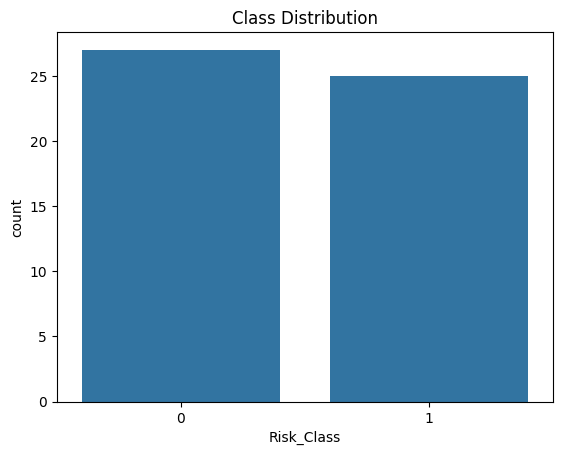

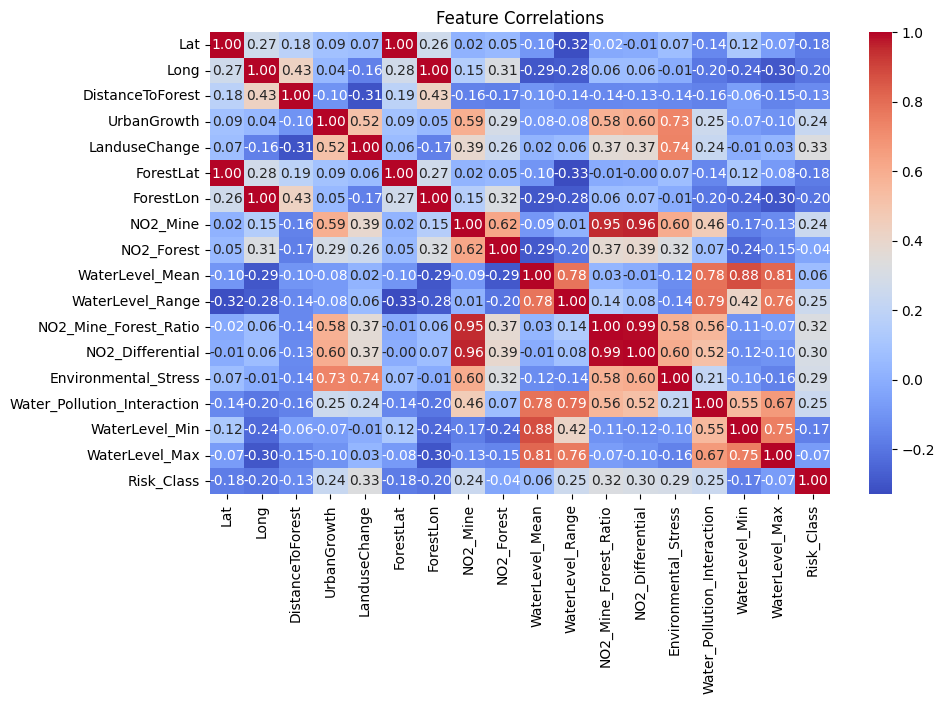

In [180]:
sns.countplot(x="Risk_Class", data=df)
plt.title("Class Distribution")

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlations")


 **Insights:**
- Dataset is imbalanced
- Location features (Lat, Long) may influence model
- Some environmental variables show moderate correlation with Risk


In [183]:
X = df.drop(columns=["Risk_Class"])
y = df["Risk_Class"]

In [184]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)


In [185]:
model = LogisticRegression(
    multi_class="multinomial", 
    solver="lbfgs", 
    max_iter=500, 
    class_weight='balanced'
)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500,
                   multi_class='multinomial')

In [186]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6



### Model Evaluation Summary

- Test accuracy: 83.3%
- Class 0 (Low Risk): perfect recall, some false positives
- Class 1 (High Risk): perfect precision, but missed some positives
- Overall, the model performs well given the small dataset.
- It leans slightly toward avoiding false alarms, which may be suitable for risk-sensitive applications.
